In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from distfit import distfit
from scipy import stats
import seaborn as sns
import random
c = ['#5effb4', '#8582e8', '#ff8138']

In [2]:
class DataSet:
    def __init__(self):
        purdue = pd.read_csv('Purdue-University.csv')
        netl = pd.read_csv('NETL-DOE.csv')
        mask1 = purdue['U.S._STATE'] == 'Texas'
        data1 = purdue[mask1][['MONTH', 'NERC.REGION',
                              'CLIMATE.CATEGORY', 'OUTAGE.START.HOUR',
                              'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']]
        mask2 = netl['Year'] > 2016
        data2 = netl[mask2][['Month', 'NERC Region', 'Climate Category',
                            'Start Hour', 'Outage Duration',
                            'Number of Customers Affected']]
        columns = ['month', 'region', 'climate', 'start', 'duration', 'customers']
        data2.columns, data1.columns = columns, columns
        data = pd.concat([data1, data2])
        data.dropna(inplace=True)
        data['month'] = data['month'].astype(int)
        self.features = data[['month', 'region', 'climate', 'start', 'customers']]
        self.target = data['duration']

### Remove Nulls

In [3]:
data = DataSet()

### Dummy Variables

In [21]:
month_d = pd.get_dummies(data.features['month'], prefix='month')
region_d = pd.get_dummies(data.features['region'], prefix='region')
climate_d = pd.get_dummies(data.features['climate'], prefix='climate')
start_d = pd.get_dummies(data.features['start'], prefix='start')
X = pd.concat([month_d, region_d, climate_d, start_d], axis=1)

### Simple Error Estimation

In [71]:
q1 = data.target.quantile(0.96)
q2 = data.target.quantile(0.01)
data_no_out = data.target[data.target < q1]
data_no_out = data_no_out[data_no_out > q2]
mean = np.mean(data_no_out)
re = data_no_out - mean

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.484675] [loc=-0.000 scale=28.249]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.360073] [loc=-20.359 scale=20.359]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.277266] [loc=-32.810 scale=12.451]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.484911] [loc=-0.000 scale=21.461]
[distfit] >INFO> [t         ] [0.17 sec] [RSS: 0.40616] [loc=-14.636 scale=7.079]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 0.279661] [loc=-16.789 scale=5.522]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.252816] [loc=-20.359 scale=39.593]
[distfit] >INFO> [lognorm   ] [0.02 sec] [RSS: 0.255249] [loc=-20.415 scale=6.843]
[distfit] >INFO> [beta      ] [0.07 sec] [RSS: 0.255101] [loc=-20.359 scale=2246.264]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.531656] [loc=-20.359 scale=152.700]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.48636] [loc=-9434.645 scale=1248.305]


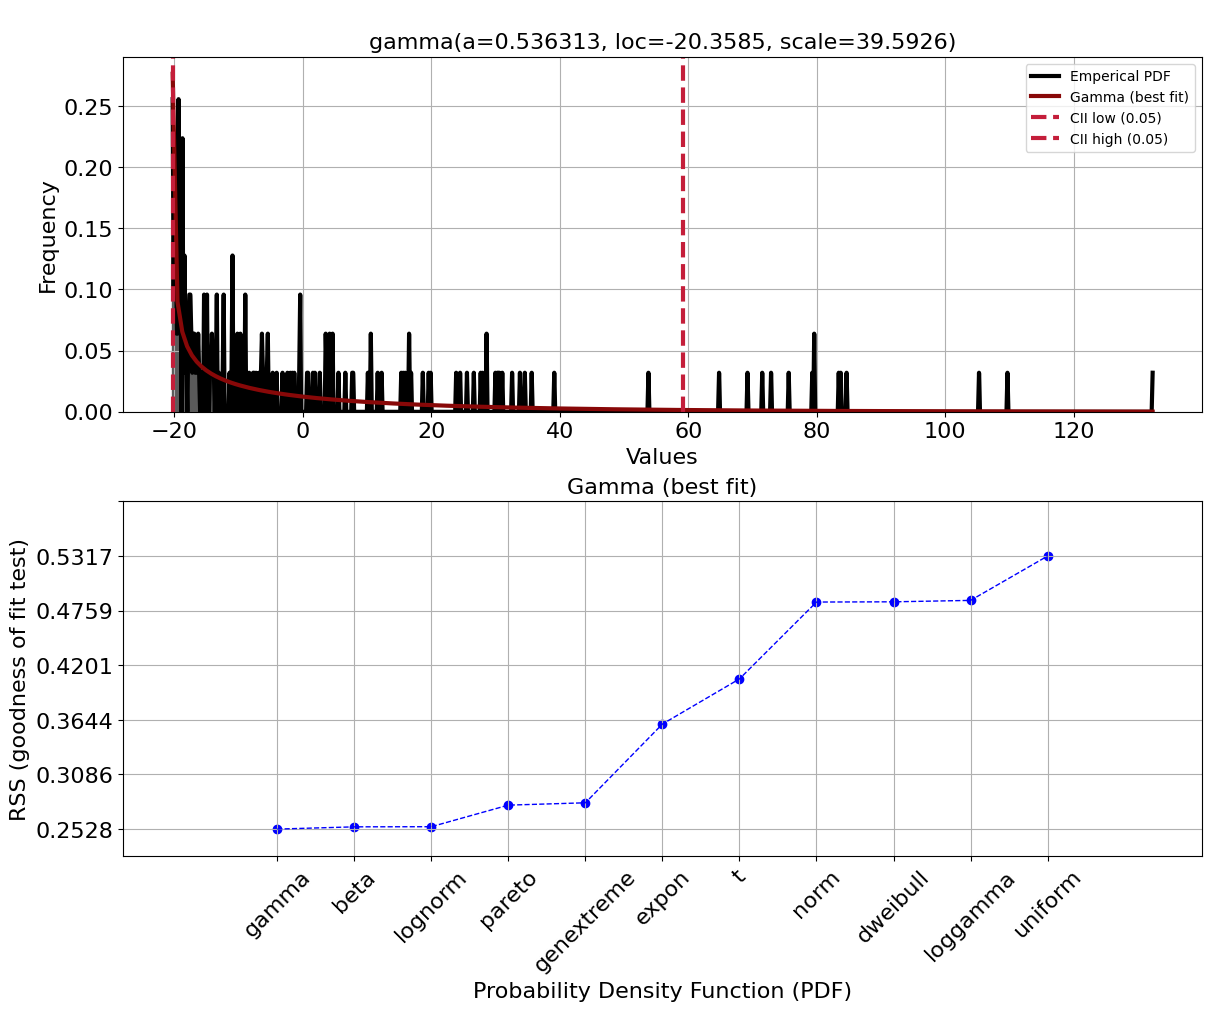

In [72]:
dist = distfit(alpha=0.05, bins=1000)
dist.fit_transform(re)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), constrained_layout = True)
dist.plot(chart='PDF', ax=axs[0])
dist.plot_summary(ax=axs[1])
pd.DataFrame(dist.summary).to_csv('PopularPDFs.csv')
plt.savefig('FitPDFs.jpg', dpi=200, bbox_inches='tight')

In [73]:
a, loc, shape = 0.5363125081516416, -20.358520325346348, 39.59262124980804

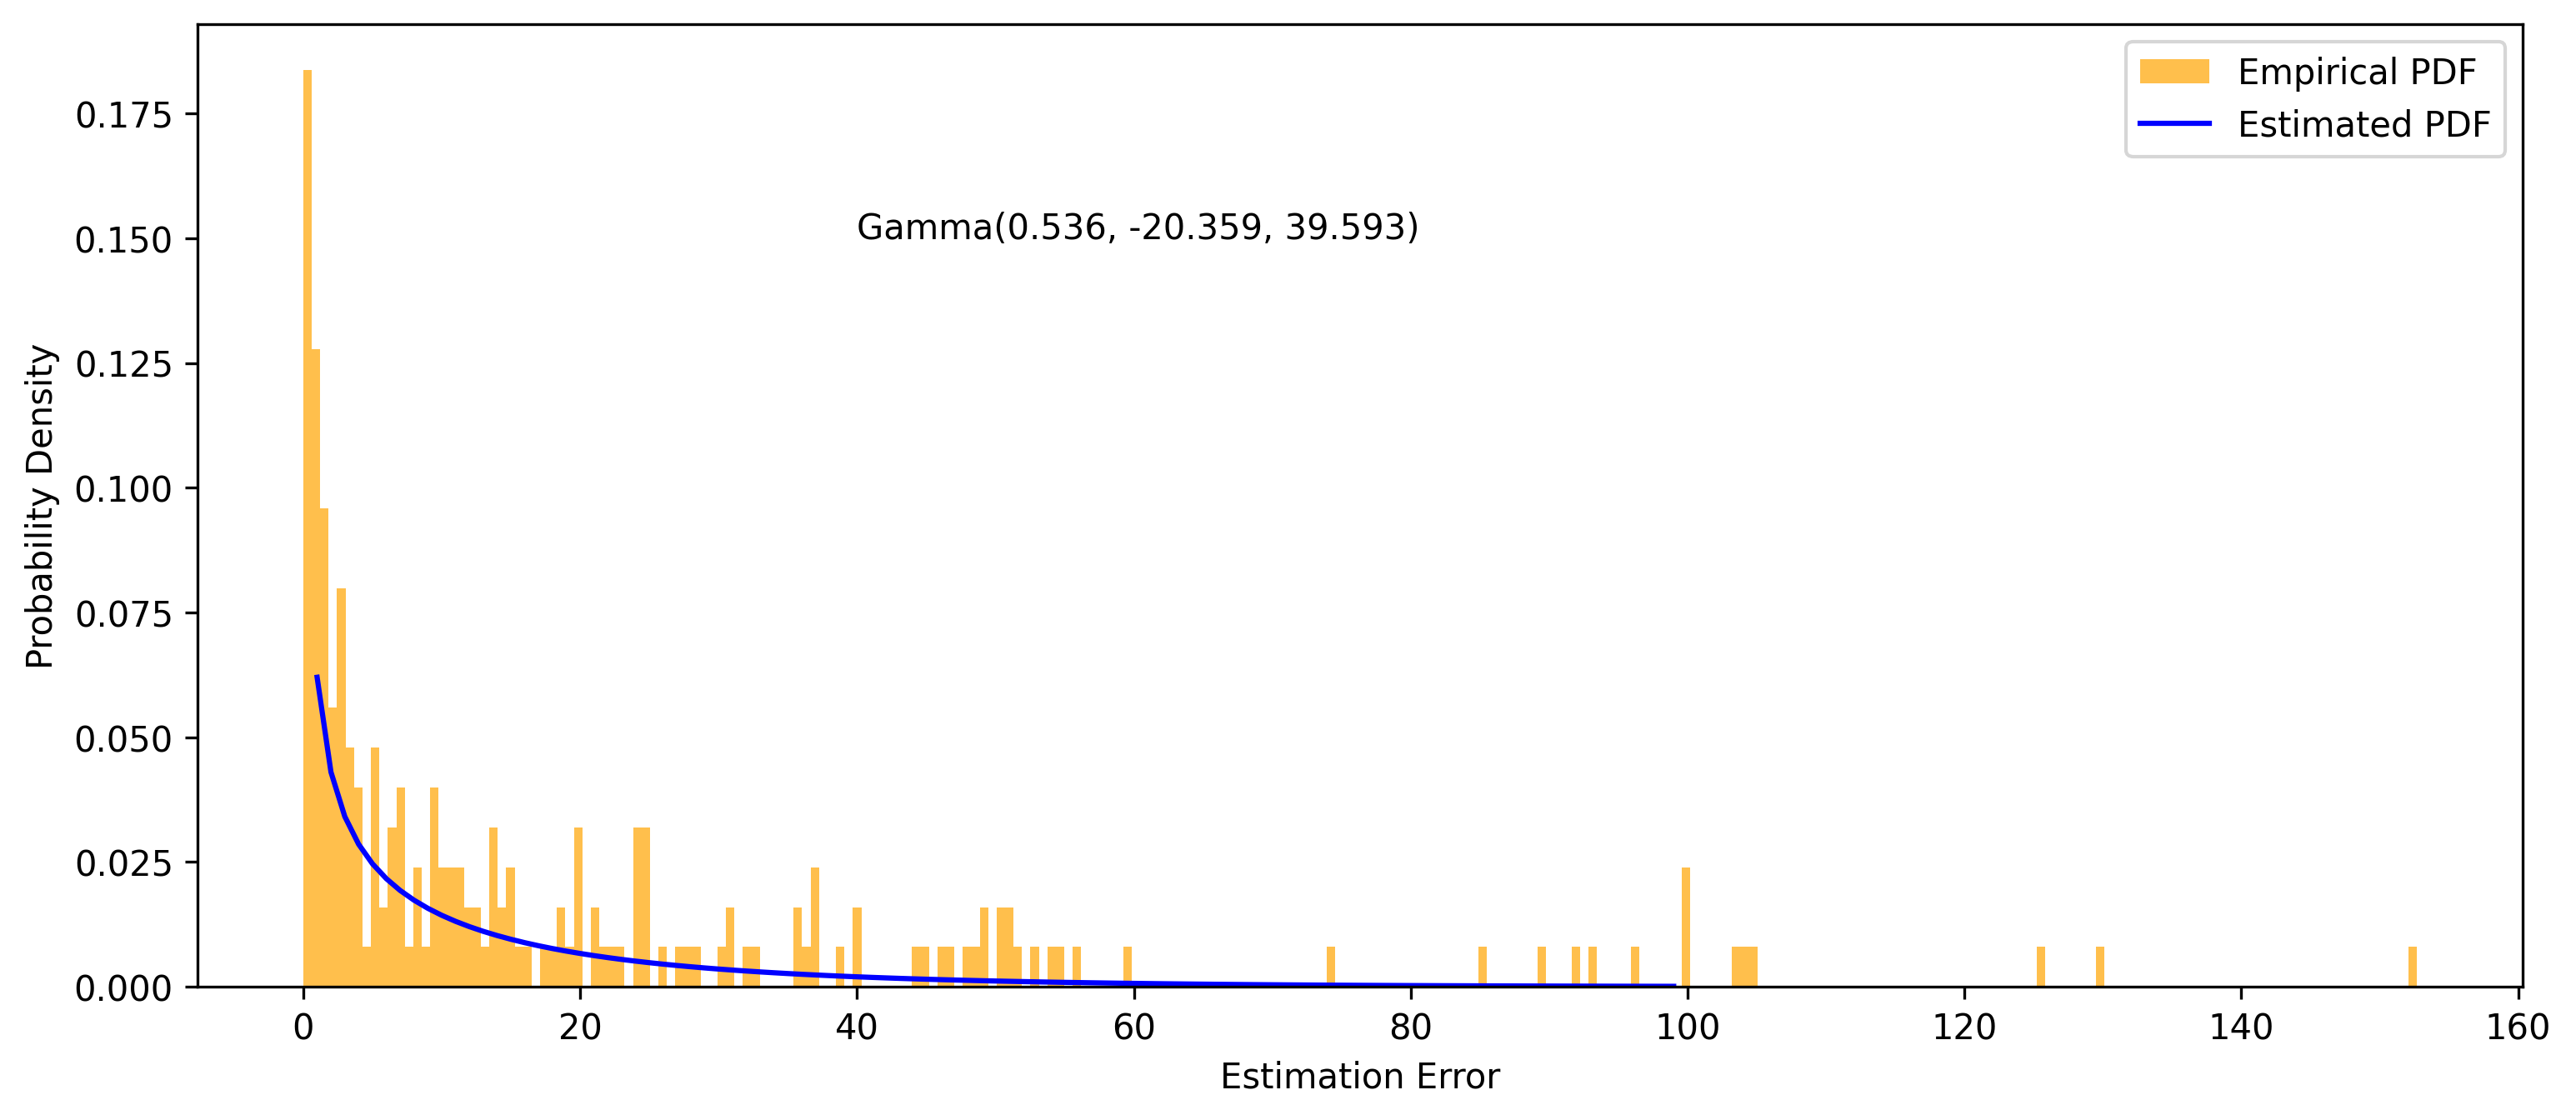

In [78]:
x = np.linspace(loc, max(re) + abs(min(re)), 100)
best_dist = stats.gamma(a, loc, shape ).pdf(x)
figure1 = plt.figure(figsize=(12, 5), dpi=300)
plt.hist(re + abs(min(re)), bins=250, label='Empirical PDF', density=True, color='orange', alpha=0.7)
plt.plot(best_dist, label='Estimated PDF', color='blue')
plt.xlabel('Estimation Error')
plt.ylabel('Probability Density')
plt.style.use('default')
plt.text(x=40, y=0.15, s=f'Gamma({a:0.3f}, {loc:0.3f}, {shape:0.3f})')
plt.legend()
plt.savefig('GammaFitted.jpg', dpi=200, bbox_inches='tight')

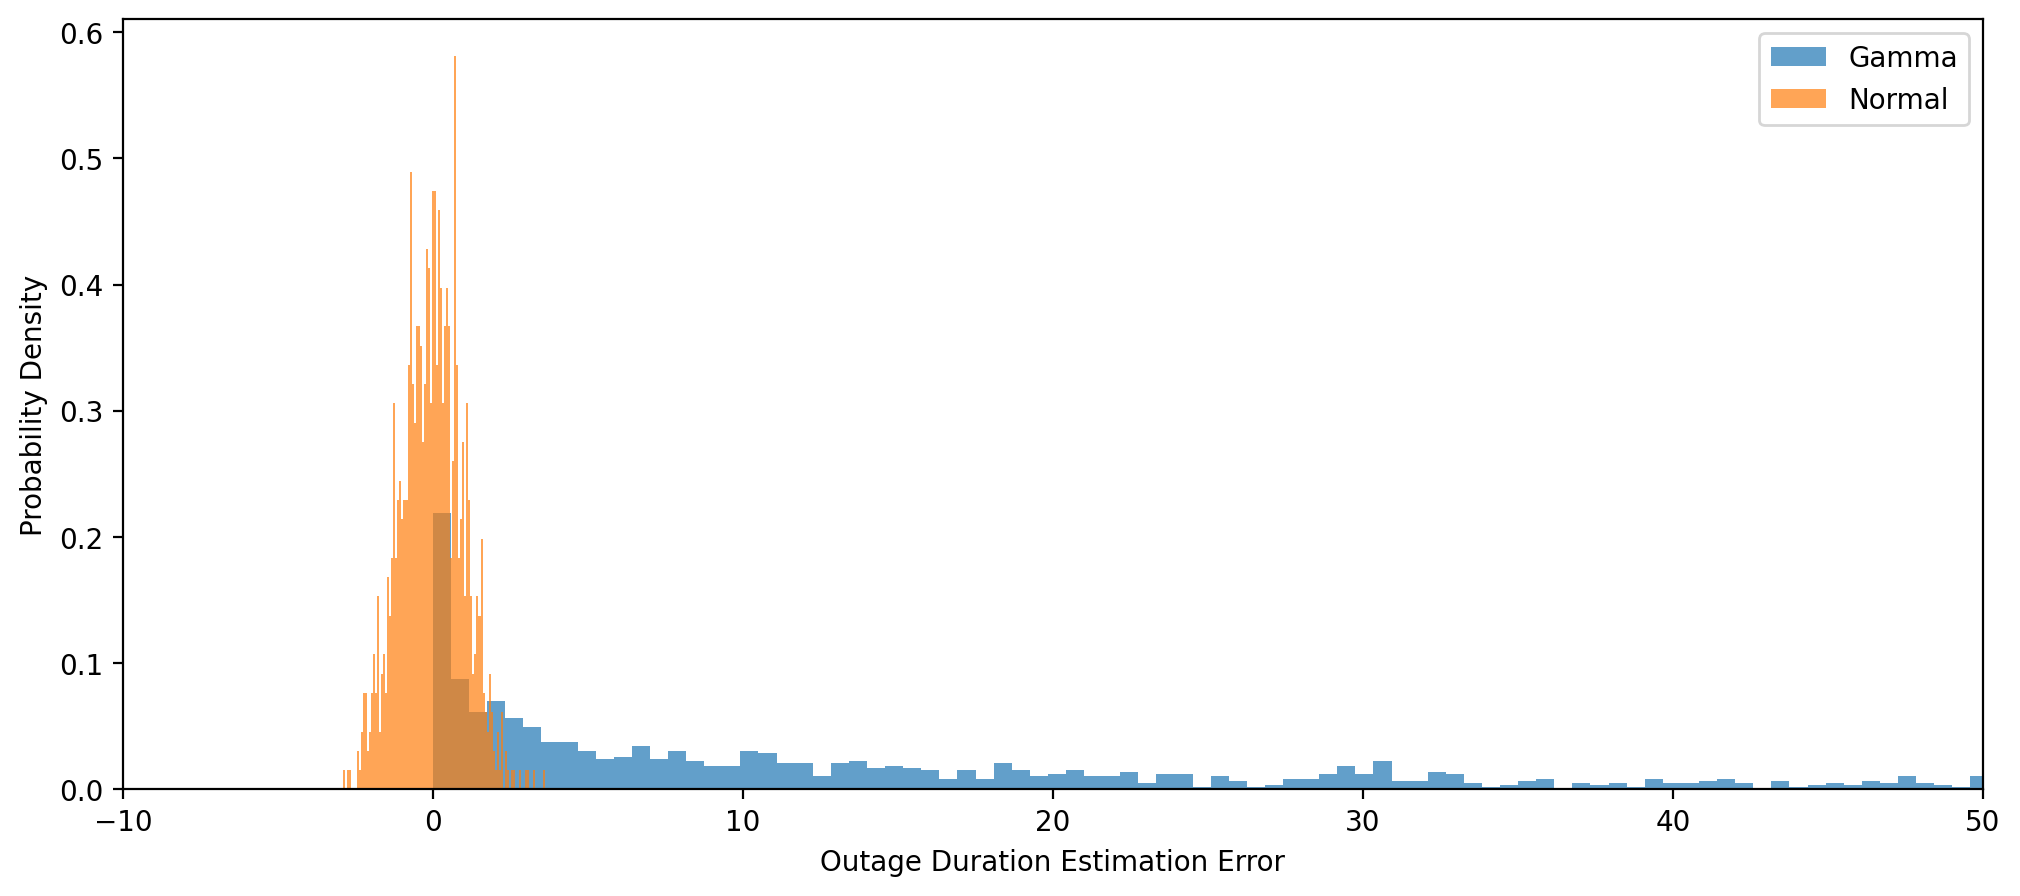

In [75]:
# Create a gamma distribution
gamma_dist = stats.gamma(a, scale=shape)

# Generate random samples from the gamma distribution
gamma_samples = gamma_dist.rvs(1000)
gamma_cdf = gamma_dist.cdf(gamma_samples)

# Transform the gamma samples to normal samples
normal_samples = stats.norm.ppf(gamma_dist.cdf(gamma_samples))
normal_cdf = stats.norm.cdf(normal_samples)

# Plot the gamma and normal distributions
figure2 = plt.figure(figsize=(12, 5), dpi=200)

plt.hist(gamma_samples, bins=500, density=True,  alpha=0.7, label='Gamma')
plt.hist(normal_samples, bins=100, density=True, alpha=0.7, label='Normal')
plt.xlabel('Outage Duration Estimation Error')
plt.ylabel('Probability Density')
plt.style.use('default')
plt.xlim((-10, 50))
plt.legend()
plt.savefig('TransToNorm.jpg', bbox_inches='tight')

In [76]:
probs = [stats.norm.cdf(x) for x in normal_samples[0: 100]]
ranges = np.linspace(-3.5, 3.5, 8)
intervals = np.linspace(-3, 3, 7)
prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
range_trans = {key: stats.gamma.ppf(stats.norm.cdf(key), a=a, loc=loc, scale=shape) + mean for key in intervals}

scenarios = {'Norm Error': [], 'Gamma Scenario': [], 'Probability': []}
for i in probs:
    for key in intervals:
        if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
            scenarios['Norm Error'].append(key)
            scenarios['Probability'].append(prob_ranges[key][1]-prob_ranges[key][0])
            scenarios['Gamma Scenario'].append(range_trans[key]) #  - abs(min(re)) + mean
            break
pd.DataFrame(scenarios).to_csv('Outage Scenarios.csv')

In [77]:
pd.DataFrame(scenarios)

,Norm Error,Gamma Scenario,Probability
0,-2.0,0.077417,0.060598
1,-1.0,1.092246,0.241730
2,-1.0,1.092246,0.241730
3,-2.0,0.077417,0.060598
4,0.0,10.304032,0.382925
...,...,...,...
95,3.0,208.317492,0.005977
96,0.0,10.304032,0.382925
97,0.0,10.304032,0.382925
98,0.0,10.304032,0.382925
